<a href="https://colab.research.google.com/github/K-3620/LSTM-/blob/main/LSTM%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dd = pd.read_csv('/content/drive/My Drive/데이터수집/2010년/2010년.csv',index_col=0)
dd

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,7540,7820,7480,7520,177197,-0.007916
2010-01-05,7490,7580,7350,7500,214314,-0.002660
2010-01-06,7500,7500,7320,7350,81874,-0.020000
2010-01-07,7350,7420,7200,7210,106474,-0.019048
2010-01-08,7220,7330,7220,7240,61393,0.004161
...,...,...,...,...,...,...
2010-12-24,5120,5120,4990,5070,87767,-0.005882
2010-12-27,5080,5120,5020,5050,49362,-0.003945
2010-12-28,5030,5140,5030,5110,80644,0.011881


In [ ]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    251 non-null    object 
 1   Open    251 non-null    int64  
 2   High    251 non-null    int64  
 3   Low     251 non-null    int64  
 4   Close   251 non-null    int64  
 5   Volume  251 non-null    int64  
 6   Change  251 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 13.9+ KB


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from keras.models import Model,Sequential
from keras.layers import Input,Dense,LSTM,Bidirectional
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM 
# import lstm, time #도움을 주는 라이브러리들

In [ ]:
df_price = pd.read_csv('/content/drive/My Drive/데이터수집/2010년/2010년.csv',encoding='utf8')
df_price

,Date,Open,High,Low,Close,Volume,Change
0,2010-01-04,7540,7820,7480,7520,177197,-0.007916
1,2010-01-05,7490,7580,7350,7500,214314,-0.002660
2,2010-01-06,7500,7500,7320,7350,81874,-0.020000
3,2010-01-07,7350,7420,7200,7210,106474,-0.019048
4,2010-01-08,7220,7330,7220,7240,61393,0.004161
...,...,...,...,...,...,...,...
246,2010-12-24,5120,5120,4990,5070,87767,-0.005882
247,2010-12-27,5080,5120,5020,5050,49362,-0.003945
248,2010-12-28,5030,5140,5030,5110,80644,0.011881
249,2010-12-29,5150,5330,5120,5300,179855,0.037182


In [ ]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    251 non-null    object 
 1   Open    251 non-null    int64  
 2   High    251 non-null    int64  
 3   Low     251 non-null    int64  
 4   Close   251 non-null    int64  
 5   Volume  251 non-null    int64  
 6   Change  251 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 13.9+ KB


In [ ]:
#날짜 datetime 포맷으로 변환
pd.to_datetime(df_price['Date'], format='%Y-%m-%d')

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price['Year'] =df_price['Date'].dt.year
df_price['Month'] =df_price['Date'].dt.month
df_price['Day'] =df_price['Date'].dt.day

In [ ]:
# Normalization - 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_clos = ['Open','High','Low','Close','Volume']
df_scaled = scaler.fit_transform(df_price[scale_clos])

df_scaled = pd.DataFrame(data=df_scaled,columns=scale_clos)

df_scaled.head()

,Open,High,Low,Close,Volume
0,1.000000,1.000000,1.000000,1.000000,0.366090
1,0.982517,0.922204,0.955172,0.993080,0.450800
2,0.986014,0.896272,0.944828,0.941176,0.148538
3,0.933566,0.870340,0.903448,0.892734,0.204682
4,0.888112,0.841167,0.910345,0.903114,0.101795


In [ ]:
train = df_scaled[:200]
test = df_scaled[200:]

In [ ]:
# 학습 시킬 데이터 셋 생성 함수
# 30일 기반으로 데이터 셋 묶기
def make_dataset(data,label,window_size=30):
  feature_list =[] # 학습
  label_list =[] # 답
  for i in range(len(data)-window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  return np.array(feature_list),np.array(label_list)

In [ ]:
feature_cols = ['Open','High','Low','Volume'] # 학습 컬럼
label_cols = ['Close'] # 답 컬럼

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature,train_label = make_dataset(train_feature,train_label,30)

# train,test set 생성
X_train,X_test,y_train,y_test = \
train_test_split(train_feature,train_label,test_size=0.2,random_state=0)

test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset(실제 예측 데이터)
test_feature,test_label = make_dataset(test_feature,test_label,30)

In [ ]:
# Keras를 활용한 LSTM 모델 생성
model = Sequential()
model.add(LSTM(
    16
    ,input_shape=(train_feature.shape[1],train_feature.shape[2])
    ,activation='relu'
    ,return_sequences = False
))
model.add(Dense(1))

In [ ]:
import os
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
# 모델의 학습
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss',patience=1,verbose=1)

model.fit(X_train,y_train,epochs=200,batch_size=16
                   ,validation_data=(X_test,y_test)
                   ,callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1344      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
9/9 [==============================] - 0s 37ms/step - loss: 0.1805 - val_loss: 0.1466
Epoch 2/200
9/9 [==============================] - 0s 12ms/step - loss: 0.1292 - val_loss: 0.1082
Epoch 3/200
9/9 [==============================] - 0s 12ms/step - loss: 0.0958 - val_loss: 0.0785
Epoch 4/200
9/9 [==============================] - 0s 12ms/step - loss: 0.0675 - val_loss: 0.0502
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0388 - val_loss: 0.0179
Epoch 6/200
9/9 [=========

In [ ]:
# 예측
pred =model.predict(test_feature)

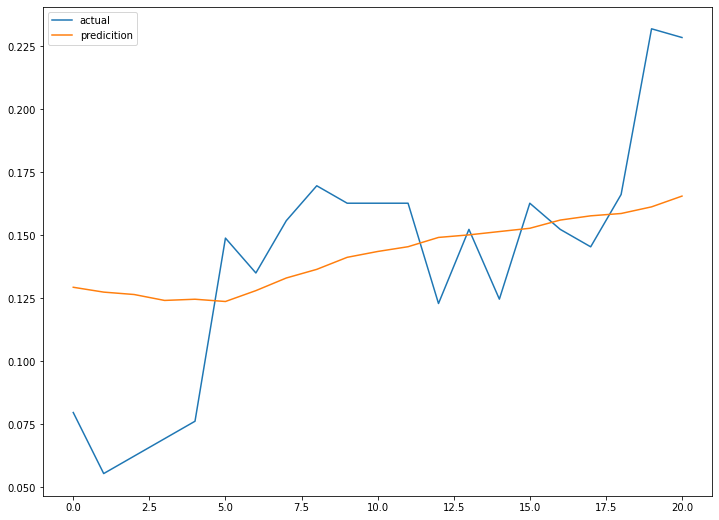

In [ ]:
# 시각화
plt.figure(figsize=(12,9))
plt.plot(test_label,label='actual')
plt.plot(pred,label='predicition')
plt.legend()
plt.show()